In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import xgboost as xgb
import tensorflow as tf
from sklearn.linear_model import Ridge
import statistics

### Data Cleansing function

In [3]:
df = pd.read_csv('datapower_v1.csv')

In [4]:
import csv

# Load CSV data into a list of lists
data = []
with open('datapower.csv', 'r') as file:
    csv_reader = csv.reader(file)
    header = next(csv_reader)  # Capture the header
    data = [row for row in csv_reader]

# Convert the list of lists to a transposed list of columns
columns = list(zip(*data))

# Identify empty or predominantly empty columns
empty_column_indices = []
for index, column in enumerate(columns):
    # Count empty strings in the column
    empty_count = sum(1 for cell in column if cell == '')
    if empty_count == len(column):  # All values are empty
        empty_column_indices.append(index)
    elif empty_count / len(column) > 0.5:  # More than 50% values are empty
        empty_column_indices.append(index)

# Print indices of empty columns and their names
print("Empty or predominantly empty column indices and names:")
for index in empty_column_indices:
    print(f"Index: {index}, Name: {header[index]}")

# Remove empty columns from the header and data
filtered_header = [name for i, name in enumerate(header) if i not in empty_column_indices]
filtered_data = [[value for i, value in enumerate(row) if i not in empty_column_indices] for row in data]

# Check results
print("Filtered header:", filtered_header)
print("Sample row from filtered data:", filtered_data[0])

# Names of the columns to remove
columns_to_remove = ['pk_user', 'fk_referral', 'ts_created', 'username', 'password', 'pk_dwelling', 'fk_user', 'when_moved_in', 'street', 'pk_resident', 'pk_bill', 'price_posttax']

# Create a set for faster lookup
columns_to_remove_set = set(columns_to_remove)

# Find the indices of the columns to remove
indices_to_remove = [filtered_header.index(col) for col in columns_to_remove if col in filtered_header]

# Sort the indices in reverse order to avoid index shifting after removal
indices_to_remove.sort(reverse=True)

# Remove the columns from the header and data
for index in indices_to_remove:
    # Remove the column from the header
    filtered_header.pop(index)
    # Remove the column from each row in the filtered data
    filtered_data = [row[:index] + row[index+1:] for row in filtered_data]

# Now filtered_header and filtered_data have the specified columns removed
print("Updated header without specified fields:", filtered_header)
print("Sample row from updated filtered data:", filtered_data[0])

import numpy as np

# Function to safely convert values to float, replacing non-convertible values with NaN
def safe_float_convert(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

# Convert filtered data to float, handling non-convertible values
numeric_data = []
for row in filtered_data:
    converted_row = [safe_float_convert(value) for value in row]
    numeric_data.append(converted_row)

numeric_array = np.array(numeric_data)

# Replace NaN values with column-wise means
# Compute means ignoring NaNs
col_means = np.nanmean(numeric_array, axis=0)
# Find indices where NaN values are present
inds = np.where(np.isnan(numeric_array))
# Place column means in the positions where NaNs were
numeric_array[inds] = np.take(col_means, inds[1])

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(numeric_array, rowvar=False)

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Display correlation matrix with headers for better understanding
print("\nCorrelation matrix with headers:")
print("     ", "    ".join(filtered_header))
for name, row in zip(filtered_header, correlation_matrix):
    print(f"{name:10}", " ".join(f"{num:6.2f}" for num in row))
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def one_hot_encode_feature(data, headers, feature_name):
    if feature_name in headers:
        col_index = headers.index(feature_name)
        column_data = [row[col_index] for row in data]

        # Create the OneHotEncoder with no sparse argument
        encoder = OneHotEncoder()
        column_data_2d = np.array(column_data).reshape(-1, 1)
        encoded_column_data = encoder.fit_transform(column_data_2d).toarray()  # Convert sparse matrix to array immediately

        encoded_column_names = [f"{feature_name}_{category}" for category in encoder.categories_[0]]

        # Remove the original column from headers
        headers = [name for i, name in enumerate(headers) if i != col_index]
        
        # Create a new data excluding the column to be encoded
        new_data = [row[:col_index] + row[col_index+1:] for row in data]

        # Convert new_data into a numpy array for safe concatenation
        new_data_array = np.array(new_data, dtype=object)
        final_data_array = np.hstack((new_data_array, encoded_column_data))
        
        updated_headers = headers + encoded_column_names
        
        return final_data_array.tolist(), updated_headers
    else:
        print(f"Feature '{feature_name}' not found in the headers.")
        return data, headers

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from datetime import datetime

def replace_dates_with_days_measured(data, headers, start_date_col, end_date_col):
    """
    Replaces the start and end date columns with a days_measured column which is
    the difference in days between the dates.

    :param data: List of lists containing the dataset.
    :param headers: List of column headers.
    :param start_date_col: The name of the start date column.
    :param end_date_col: The name of the end date column.
    :return: Tuple of updated data and headers.
    """
    if start_date_col in headers and end_date_col in headers:
        start_index = headers.index(start_date_col)
        end_index = headers.index(end_date_col)

        # Calculate the difference in days and create the new data array
        new_data = []
        for row in data:
            start_date = datetime.strptime(row[start_index], '%Y-%m-%d')
            end_date = datetime.strptime(row[end_index], '%Y-%m-%d')
            days_measured = (end_date - start_date).days
            new_row = row[:start_index] + [days_measured] + row[start_index+1:end_index] + row[end_index+1:]
            new_data.append(new_row)

        # Update the headers
        new_headers = headers[:start_index] + ['days_measured'] + headers[start_index+1:end_index] + headers[end_index+1:]

        return new_data, new_headers
    else:
        print(f"One or both date columns not found in headers.")
        return data, headers

# Example usage:
# Assume 'filtered_data' and 'filtered_header' are defined as before
filtered_data, filtered_header = replace_dates_with_days_measured(filtered_data, filtered_header, 'date_start', 'date_end')

filtered_data, filtered_header = one_hot_encode_feature(filtered_data, filtered_header, 'compass_facing')
filtered_data, filtered_header = one_hot_encode_feature(filtered_data, filtered_header, 'type')
filtered_data, filtered_header = one_hot_encode_feature(filtered_data, filtered_header, 'material_roof')
filtered_data, filtered_header = one_hot_encode_feature(filtered_data, filtered_header, 'material_walls')
filtered_data, filtered_header = one_hot_encode_feature(filtered_data, filtered_header, 'material_windows')
filtered_data, filtered_header = one_hot_encode_feature(filtered_data, filtered_header, 'post_code')
filtered_data, filtered_header = one_hot_encode_feature(filtered_data, filtered_header, 'city')
filtered_data, filtered_header = one_hot_encode_feature(filtered_data, filtered_header, 'state')
filtered_data, filtered_header = one_hot_encode_feature(filtered_data, filtered_header, 'country')
filtered_data, filtered_header = one_hot_encode_feature(filtered_data, filtered_header, 'currency')

# Verify the results
print("Updated headers:", filtered_header)
print("Sample row from updated data:", filtered_data[0])

filtered_data = np.array(filtered_data, dtype=float)  # Ensure the data type is appropriate

kwh_index = filtered_header.index('kwh')
X = np.delete(filtered_data, kwh_index, axis=1)  # Predictors
y = filtered_data[:, kwh_index]  # Target variable

# Convert target variable to float
y = y.astype(float)


Empty or predominantly empty column indices and names:
Index: 1, Name: fk_referral
Index: 3, Name: ts_updated
Index: 4, Name: ts_deleted
Index: 5, Name: ts_last_login
Index: 8, Name: failed_attempts
Index: 12, Name: when_moved_out
Index: 13, Name: hash
Index: 50, Name: tariff
Filtered header: ['pk_user', 'ts_created', 'username', 'password', 'pk_dwelling', 'fk_user', 'when_moved_in', 'area', 'compass_facing', 'type', 'level', 'energy_grading', 'material_walls', 'material_roof', 'material_windows', 'has_double_glacing', 'has_heating', 'has_hot_water', 'has_air_conditioning', 'has_dishwasher', 'has_washer', 'has_drier', 'has_fridge', 'has_pool', 'num_entertainment', 'kwh_generation', 'street', 'city', 'state', 'country', 'post_code', 'pk_resident', 'num_age_0_to_18', 'num_age_19_to_40', 'num_age_41_to_62', 'num_age_63_to_all', 'pk_bill', 'date_start', 'date_end', 'kwh', 'currency', 'price_pretax', 'price_posttax']
Sample row from filtered data: ['1', '2024-04-11 10:10:43', 'aitor', '$2y$

/var/folders/vb/cm8xdysn1pg36sgnx27zdnx40000gn/T/ipykernel_97815/1458066794.py:78: RuntimeWarning: Mean of empty slice
  col_means = np.nanmean(numeric_array, axis=0)
/Users/einsteinium/miniforge3/envs/mlenv2023/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/einsteinium/miniforge3/envs/mlenv2023/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [5]:
#This method takes in two arrays, the training list, and the testing list
#Output: average train, average test
def avg(train_list, test_list):
    avg_train=0 
    avg_test=0
    for tr_rec, te_rec in zip(train_list, test_list):
        avg_train += np.mean(tr_rec)
        avg_test += np.mean(te_rec)
    avg_train =avg_train/len(train_list)
    avg_test = avg_test/len(test_list)
    return [avg_train, avg_test]

In [6]:
def kfold_model_and_scores(model, X_train, X_test, y_train, y_test):
    kf = KFold(n_splits=10, shuffle=True)
    mse_train = list()
    mse_test = list()
    r2_train = list()
    r2_test = list()
    for fold, (train_i, test_i) in enumerate(kf.split(X)):
        #Get training data for specific fold
        X_train, X_test = X[train_i], X[test_i]
        y_train, y_test = y[train_i], y[test_i]
    
        #fit the fold to the model
        model.fit(X_train, y_train)
    
        #predict on X_train
        y_hat_train = model.predict(X_train)
    
        #get mse for training
        train_mse = mean_squared_error(y_train, y_hat_train)
        #append the mse to the training array
        mse_train.append(train_mse)
    
        #get r2 for training
        train_r2 = r2_score(y_train, y_hat_train)
        #append the r2 to the training array
        r2_train.append(train_r2)
        
        #predict on X_Test
        y_hat_test = model.predict(X_test)
    
        #get test mse
        test_mse = mean_squared_error(y_test, y_hat_test)
        mse_test.append(test_mse)
    
        #get test r2 
        test_r2 = r2_score(y_test, y_hat_test)
        r2_test.append(test_r2)
    
        print(f'Fold {fold+1}:')
        print('Train MSE={:0.2f}, Test MSE={:0.2f}'.format(train_mse, test_mse))
        print('Train R2={:0.2f}, Test R2={:0.2f}\n'.format(train_r2, test_r2))
    
    avg_mse = avg(mse_train,mse_test)
    avg_r2 = avg(r2_train, r2_test)
    
    print('Average MSE Train:{:0.2f}\nAverage MSE Test:{:0.2f}\n\n'.format(avg_mse[0],avg_mse[1]))
    print('Average R2 Train:{:0.2f}\nAverage R2 Test:{:0.2f}'.format(avg_r2[0],avg_r2[1]))
    return [avg_mse,avg_r2]

In [9]:
## Here we store the data of each model's training MSE and R2 Score, separated by model and various type of training

one_fit = dict()
kfold_fit = dict()
neural_net_fit = dict()

### Linear Regression

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = lin_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the model performance
print('Mean Squared Error:', mse)
print('R^2 Score:', r2)

Mean Squared Error: 30785.822015148253
R^2 Score: 0.8289697615286493


In [108]:
lr_one_fit_mse = mse
lr_one_fit_r2 = r2

one_fit['Linear Regression'] = [lr_one_fit_mse, lr_one_fit_r2]

Out of curiosity, I decided to try KFold validation, with 10 folds, while still maintaining the R2 and MSE scores to see if this would improve the model at all.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
lin_model_2 = LinearRegression()

#does kFold validation on the model and outputs the scores
lr_kfold_avg_scores = kfold_model_and_scores(lin_model_2, X_train, X_test, y_train, y_test)

Fold 1:
Train MSE=24536.55, Test MSE=26166.53
Train R2=0.85, Test R2=0.82

Fold 2:
Train MSE=24193.63, Test MSE=29391.74
Train R2=0.85, Test R2=0.83

Fold 3:
Train MSE=24492.66, Test MSE=27252.88
Train R2=0.85, Test R2=0.84

Fold 4:
Train MSE=25127.54, Test MSE=20318.64
Train R2=0.85, Test R2=0.88

Fold 5:
Train MSE=24175.05, Test MSE=30271.13
Train R2=0.85, Test R2=0.83

Fold 6:
Train MSE=23766.95, Test MSE=33677.03
Train R2=0.85, Test R2=0.78

Fold 7:
Train MSE=23326.06, Test MSE=38875.62
Train R2=0.86, Test R2=0.73

Fold 8:
Train MSE=24451.17, Test MSE=28026.85
Train R2=0.85, Test R2=0.84

Fold 9:
Train MSE=24214.90, Test MSE=30858.89
Train R2=0.85, Test R2=0.80

Fold 10:
Train MSE=24370.95, Test MSE=28396.82
Train R2=0.85, Test R2=0.81

Average MSE Train:24265.55
Average MSE Test:29323.61


Average R2 Train:0.85
Average R2 Test:0.82


In [13]:
kfold_fit['Linear Regression'] = [statistics.mean(lr_kfold_avg_scores[0]), statistics.mean(lr_kfold_avg_scores[1])]

We can see from these results that there may be some slight overfitting, as the MSE and R2 scores are slightly higher during training, but drop slightly during testing. 

Let's try using L2 Regularization, just to see what happens.

In [16]:
from sklearn.linear_model import Ridge

lin_model_3 = Ridge(alpha=100)

lin_model_3.fit(X_train, y_train)

y_hat = lin_model_3.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)

# Output the model performance
print('Mean Squared Error:', mse)
print('R^2 Score:', r2)

Mean Squared Error: 28219.34578497662
R^2 Score: 0.8149464494207638


In [17]:
lr_ridge_mse = mse
lr_ridge_r2 = r2

one_fit['L2 Regularization Regression'] = [lr_ridge_mse, lr_ridge_r2]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
lin_model_4 = Ridge(alpha=100)

#does kFold validation on the model and outputs the scores
lr_ridge_kfold = kfold_model_and_scores(lin_model_4, X_train, X_test, y_train, y_test)

Fold 1:
Train MSE=25847.58, Test MSE=24148.73
Train R2=0.84, Test R2=0.85

Fold 2:
Train MSE=25126.89, Test MSE=30972.83
Train R2=0.85, Test R2=0.81

Fold 3:
Train MSE=25242.84, Test MSE=30034.26
Train R2=0.85, Test R2=0.81

Fold 4:
Train MSE=25755.25, Test MSE=25209.95
Train R2=0.84, Test R2=0.85

Fold 5:
Train MSE=25974.38, Test MSE=22721.04
Train R2=0.84, Test R2=0.86

Fold 6:
Train MSE=25507.18, Test MSE=28041.78
Train R2=0.84, Test R2=0.82

Fold 7:
Train MSE=25250.91, Test MSE=29870.30
Train R2=0.85, Test R2=0.82

Fold 8:
Train MSE=25548.53, Test MSE=26904.00
Train R2=0.84, Test R2=0.83

Fold 9:
Train MSE=26026.04, Test MSE=22538.51
Train R2=0.84, Test R2=0.85

Fold 10:
Train MSE=25262.34, Test MSE=29623.23
Train R2=0.84, Test R2=0.84

Average MSE Train:25554.19
Average MSE Test:27006.46


Average R2 Train:0.84
Average R2 Test:0.83


In [19]:
kfold_fit['L2 Regularization Regression'] = [statistics.mean(lr_ridge_kfold[0]), statistics.mean(lr_ridge_kfold[1])]

Did any of this help? Not particularly, it seems.

### SVM
#### It may be worth metnioning that it's better to use a Linear SVR. Look into this though.

In [55]:
svr_model = SVR()

params = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100, 1000]}

gs = GridSearchCV(estimator = svr_model, param_grid=params, cv=5, scoring = 'neg_mean_squared_error', verbose = 1)
%time gs = gs.fit(X_train, y_train)

print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
time = gs.cv_results_['mean_fit_time']
params = gs.cv_results_['params']

Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: user 19min 2s, sys: 1.82 s, total: 19min 4s
Wall time: 19min 14s
Best: -21693.785738 using {'C': 1000, 'kernel': 'rbf'}


In [56]:

svr_model = SVR()

params = {'kernel':('linear', 'rbf'), 'C':[1000,5000,10000]}

gs = GridSearchCV(estimator = svr_model, param_grid=params, cv=5, scoring = 'neg_mean_squared_error', verbose = 1)
%time gs = gs.fit(X_train, y_train)

print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
time = gs.cv_results_['mean_fit_time']
params = gs.cv_results_['params']

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 1h 24min 57s, sys: 6.65 s, total: 1h 25min 4s
Wall time: 1h 30min 4s
Best: -21579.582589 using {'C': 5000, 'kernel': 'rbf'}


In [53]:
from sklearn.svm import SVR
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

svr_model = SVR(C=5000, kernel='rbf')

svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the model performance
print('Mean Squared Error:', mse)
print('R^2 Score:', r2)

Mean Squared Error: 23347.404218438704
R^2 Score: 0.857980922633531


In [54]:
svr_mse = mse
svr_r2 = r2

one_fit['SVR'] = [svr_mse, svr_r2]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
svr_model_2 = SVR(C=5000, kernel='rbf')

svr_kfold =  kfold_model_and_scores(svr_model_2,X_train, X_test, y_train, y_test)

Fold 1:
Train MSE=20148.64, Test MSE=24010.90
Train R2=0.88, Test R2=0.85

Fold 2:
Train MSE=20536.96, Test MSE=21510.06
Train R2=0.88, Test R2=0.84

Fold 3:
Train MSE=20430.76, Test MSE=22223.49
Train R2=0.88, Test R2=0.85

Fold 4:
Train MSE=20782.06, Test MSE=18867.10
Train R2=0.87, Test R2=0.90

Fold 5:
Train MSE=20564.32, Test MSE=23862.36
Train R2=0.87, Test R2=0.86

Fold 6:
Train MSE=21021.21, Test MSE=17501.69
Train R2=0.87, Test R2=0.89

Fold 7:
Train MSE=20553.03, Test MSE=22234.37
Train R2=0.87, Test R2=0.87

Fold 8:
Train MSE=20598.75, Test MSE=20950.63
Train R2=0.87, Test R2=0.88

Fold 9:
Train MSE=20477.80, Test MSE=20136.94
Train R2=0.88, Test R2=0.87

Fold 10:
Train MSE=20248.29, Test MSE=23534.07
Train R2=0.88, Test R2=0.86

Average MSE Train:20536.18
Average MSE Test:21483.16


Average R2 Train:0.87
Average R2 Test:0.87


In [56]:
kfold_fit['SVR'] = [statistics.mean(svr_kfold[0]), statistics.mean(svr_kfold[1])]

In [58]:
print(kfold_fit)
print(one_fit)

{'lr': [26794.579762855996, 0.8338592682323022], 'lr_ridge': [26280.328487731334, 0.8391880018774096], 'svr': [21009.671108115384, 0.8711689518250866]}
{'lr_one_fit': [30817.741986354526, 0.8182285225064556], 'lr_ridge': [28219.34578497662, 0.8149464494207638], 'svr': [23347.404218438704, 0.857980922633531]}


### XGBoost

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor()

params = {
    'n_estimators':[100,500,1000,5000,10000,20000],
    'max_depth':[10,25,50,75,100,250,500,750,1000]
}

gs = GridSearchCV(estimator = xgb_model, param_grid=params, cv=5, scoring = 'neg_mean_squared_error', verbose = 1)
%time gs = gs.fit(X_train, y_train)

In [27]:
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
time = gs.cv_results_['mean_fit_time']
params = gs.cv_results_['params']

Best: -25890.614022 using {'max_depth': 10, 'n_estimators': 100}


In [28]:
params = {
    'n_estimators':[3,5,8,10],
    'max_depth':[10,25,50,75,100]
}

gs = GridSearchCV(estimator = xgb_model, param_grid=params, cv=5, scoring = 'neg_mean_squared_error', verbose = 1)
%time gs = gs.fit(X_train, y_train)

print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
time = gs.cv_results_['mean_fit_time']
params = gs.cv_results_['params']

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 10 s, sys: 6.4 s, total: 16.4 s
Wall time: 2.63 s
Best: -24958.883345 using {'max_depth': 10, 'n_estimators': 8}


In [61]:
params = {
    'n_estimators':[3,5,8,10],
    'max_depth':[1,2,3,4,5,6,7,8,9,10]
}

gs = GridSearchCV(estimator = xgb_model, param_grid=params, cv=5, scoring = 'neg_mean_squared_error', verbose = 1)
%time gs = gs.fit(X_train, y_train)

print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
time = gs.cv_results_['mean_fit_time']
params = gs.cv_results_['params']

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: user 10.5 s, sys: 7.33 s, total: 17.8 s
Wall time: 2.74 s
Best: -22270.496344 using {'max_depth': 3, 'n_estimators': 10}


In [61]:
xgb_model = xgb.XGBRegressor(max_depth = 3, n_estimators = 10)

xgb_model.fit(X_train,y_train)

y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the model performance
print('Mean Squared Error:', mse)
print('R^2 Score:', r2)

Mean Squared Error: 19531.46064825682
R^2 Score: 0.8758896521597455


In [62]:
xgb_mse = mse
xgb_r2 = r2

one_fit['XGBoost'] = [xgb_mse,xgb_r2]
one_fit

{'lr_one_fit': [30817.741986354526, 0.8182285225064556],
 'lr_ridge': [28219.34578497662, 0.8149464494207638],
 'svr': [23347.404218438704, 0.857980922633531],
 'xgb': [19531.46064825682, 0.8758896521597455]}

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
xgb_model_2 = xgb.XGBRegressor(max_depth = 10, n_estimators = 8)

xgb_kfold = kfold_model_and_scores(xgb_model_2,X_train, X_test, y_train, y_test)

Fold 1:
Train MSE=4582.21, Test MSE=27794.22
Train R2=0.97, Test R2=0.84

Fold 2:
Train MSE=3967.90, Test MSE=27220.63
Train R2=0.98, Test R2=0.83

Fold 3:
Train MSE=4040.17, Test MSE=25946.03
Train R2=0.98, Test R2=0.84

Fold 4:
Train MSE=4595.01, Test MSE=25117.66
Train R2=0.97, Test R2=0.82

Fold 5:
Train MSE=4216.21, Test MSE=26582.91
Train R2=0.97, Test R2=0.82

Fold 6:
Train MSE=4178.83, Test MSE=29306.46
Train R2=0.97, Test R2=0.82

Fold 7:
Train MSE=4913.34, Test MSE=24977.22
Train R2=0.97, Test R2=0.85

Fold 8:
Train MSE=4107.46, Test MSE=28730.51
Train R2=0.97, Test R2=0.84

Fold 9:
Train MSE=4566.62, Test MSE=28135.71
Train R2=0.97, Test R2=0.83

Fold 10:
Train MSE=4477.23, Test MSE=25550.08
Train R2=0.97, Test R2=0.85

Average MSE Train:4364.50
Average MSE Test:26936.14


Average R2 Train:0.97
Average R2 Test:0.83


In [65]:
kfold_fit['XGBoost'] = [statistics.mean(xgb_kfold[0]), statistics.mean(xgb_kfold[1])]
kfold_fit

{'lr': [26794.579762855996, 0.8338592682323022],
 'lr_ridge': [26280.328487731334, 0.8391880018774096],
 'svr': [21009.671108115384, 0.8711689518250866],
 'xgb': [15650.319419591355, 0.9036774339465912]}

### Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

rfr_model = RandomForestRegressor()

params = {
    'n_estimators':[1000, 2500,5000,7500,10_000],
    'max_depth':[10,25,50,75,100,250]
}

gs = GridSearchCV(estimator = rfr_model, param_grid=params, cv=5, scoring = 'neg_mean_squared_error', verbose = 1)
%time gs = gs.fit(X_train, y_train)

print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
time = gs.cv_results_['mean_fit_time']
params = gs.cv_results_['params']

Fitting 5 folds for each of 30 candidates, totalling 150 fits
CPU times: user 50min 22s, sys: 14.2 s, total: 50min 37s
Wall time: 51min 25s
Best: -23796.011705 using {'max_depth': 10, 'n_estimators': 1000}


In [25]:
rfr_model = RandomForestRegressor()

params = {
    'n_estimators':[500,600,700,800,900,1000],
    'max_depth':[1,2,3,4,5]
}

gs = GridSearchCV(estimator = rfr_model, param_grid=params, cv=5, scoring = 'neg_mean_squared_error', verbose = 1)
%time gs = gs.fit(X_train, y_train)

print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
time = gs.cv_results_['mean_fit_time']
params = gs.cv_results_['params']

Fitting 5 folds for each of 30 candidates, totalling 150 fits
CPU times: user 2min 9s, sys: 540 ms, total: 2min 9s
Wall time: 2min 11s
Best: -21216.243449 using {'max_depth': 4, 'n_estimators': 700}


In [67]:
from sklearn.ensemble import RandomForestRegressor

rfr_model_2 = RandomForestRegressor(max_depth=4, n_estimators=700)

rfr_model_2.fit(X_train, y_train)

y_pred = rfr_model_2.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the model performance
print('Mean Squared Error:', mse)
print('R^2 Score:', r2)

Mean Squared Error: 22736.389866151807
R^2 Score: 0.8541521554937088


In [68]:
rf_mse = mse
rf_r2 = r2

one_fit['Random Forest'] = [rf_mse,rf_r2]
one_fit

{'lr_one_fit': [30817.741986354526, 0.8182285225064556],
 'lr_ridge': [28219.34578497662, 0.8149464494207638],
 'svr': [23347.404218438704, 0.857980922633531],
 'xgb': [19531.46064825682, 0.8758896521597455],
 'rf': [22736.389866151807, 0.8541521554937088]}

In [69]:
rfr_model_3 = RandomForestRegressor(max_depth=4, n_estimators=700) 

rf_kfold = kfold_model_and_scores(xgb_model_2,X_train, X_test, y_train, y_test)

Fold 1:
Train MSE=4979.49, Test MSE=30108.60
Train R2=0.97, Test R2=0.82

Fold 2:
Train MSE=4509.35, Test MSE=22346.05
Train R2=0.97, Test R2=0.85

Fold 3:
Train MSE=3963.52, Test MSE=25906.29
Train R2=0.98, Test R2=0.85

Fold 4:
Train MSE=4301.65, Test MSE=28441.53
Train R2=0.97, Test R2=0.83

Fold 5:
Train MSE=4509.08, Test MSE=32670.83
Train R2=0.97, Test R2=0.77

Fold 6:
Train MSE=4603.01, Test MSE=21569.07
Train R2=0.97, Test R2=0.87

Fold 7:
Train MSE=4063.72, Test MSE=31821.42
Train R2=0.98, Test R2=0.79

Fold 8:
Train MSE=4115.45, Test MSE=28930.76
Train R2=0.97, Test R2=0.83

Fold 9:
Train MSE=4417.67, Test MSE=27560.26
Train R2=0.97, Test R2=0.83

Fold 10:
Train MSE=4294.35, Test MSE=29290.75
Train R2=0.97, Test R2=0.82

Average MSE Train:4375.73
Average MSE Test:27864.56


Average R2 Train:0.97
Average R2 Test:0.83


In [70]:
kfold_fit['Random Forest'] = [statistics.mean(rf_kfold[0]), statistics.mean(rf_kfold[1])]
kfold_fit

{'lr': [26794.579762855996, 0.8338592682323022],
 'lr_ridge': [26280.328487731334, 0.8391880018774096],
 'svr': [21009.671108115384, 0.8711689518250866],
 'xgb': [15650.319419591355, 0.9036774339465912],
 'rf': [16120.14315907349, 0.8999937106800869]}

<h2 style ='color: red'>
    Visualizing the Networks
</h2>

In [279]:
# import seaborn as sns

df_results_one_fit = pd.DataFrame.from_dict(one_fit, orient='index')
df_results_one_fit.reset_index(inplace=True)
df_results_one_fit = df_results_one_fit.rename(columns={0:"MSE One Fit", 1:"R2 One Fit", 'index':'Model'})
df_results_one_fit["R2 One Fit"] = df_results_one_fit["R2 One Fit"].round(3)
df_results_one_fit["MSE One Fit"] = df_results_one_fit["MSE One Fit"].round(3)

df_results_2_kfold = pd.DataFrame.from_dict(kfold_fit,orient='index')
df_results_2_kfold.reset_index(inplace=True)
df_results_2_kfold = df_results_2_kfold.rename(columns={0:"MSE KFold", 1:"R2 KFold", 'index':'Model'})
df_results_2_kfold["R2 KFold"] = df_results_2_kfold["R2 KFold"].round(3)
df_results_2_kfold["MSE KFold"] = df_results_2_kfold["MSE KFold"].round(3)

df_results_combined = pd.merge(df_results_2_kfold,df_results_one_fit, on="Model")
df_results_combined

,Model,MSE KFold,R2 KFold,MSE One Fit,R2 One Fit
0,lr,26794.580,0.834,30785.822,0.829
1,lr_ridge,26280.328,0.839,28219.346,0.815
2,svr,21009.671,0.871,23347.404,0.858
3,xgb,15650.319,0.904,19531.461,0.876
4,rf,16120.143,0.900,22736.390,0.854


/var/folders/vb/cm8xdysn1pg36sgnx27zdnx40000gn/T/ipykernel_97815/3714246067.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/var/folders/vb/cm8xdysn1pg36sgnx27zdnx40000gn/T/ipykernel_97815/3714246067.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


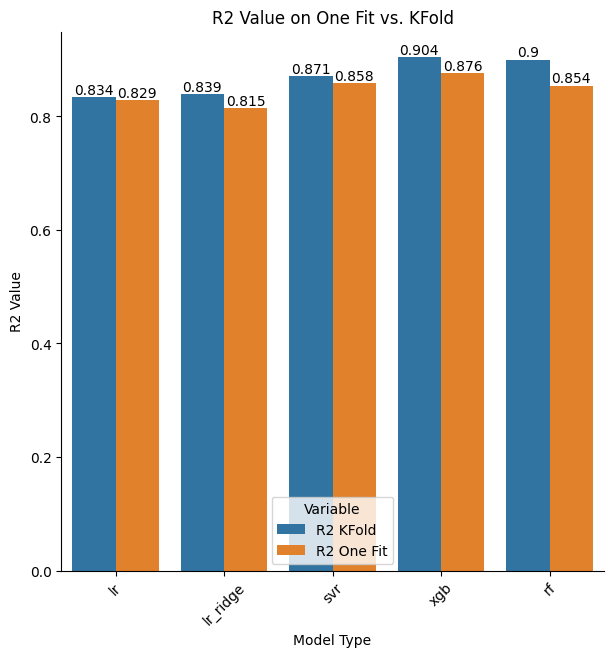

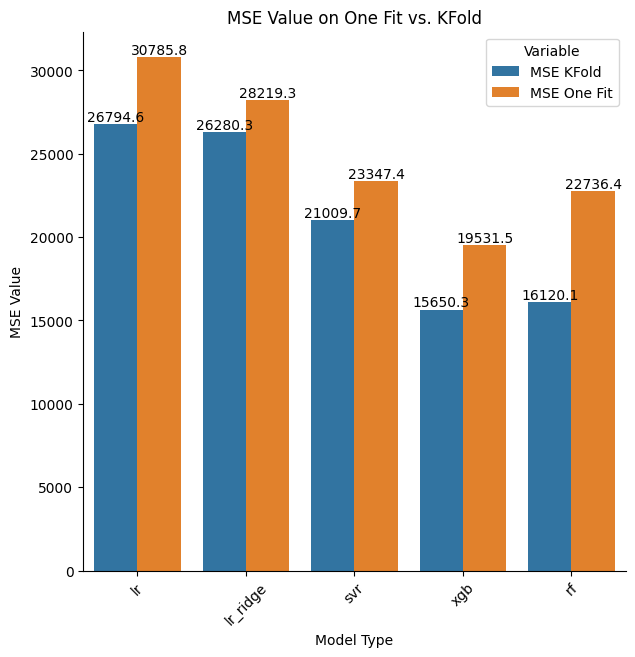

In [266]:
import seaborn as sns

results_r2 = df_results_combined[['Model', 'R2 KFold', 'R2 One Fit']].melt(id_vars='Model').rename(columns=str.title)
results_mse = df_results_combined[['Model', 'MSE KFold', 'MSE One Fit']].melt(id_vars='Model').rename(columns=str.title)

fig, ax1 = plt.subplots(figsize=(7, 7))
sns.barplot(x='Model', y='Value', hue='Variable', data=results_r2, ax=ax1)
ax1.set(xlabel ="Model Type", ylabel = "R2 Value", title ='R2 Value on One Fit vs. KFold')
for i in ax1.containers:
    ax1.bar_label(i,)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
sns.despine(fig)

fig, ax2 = plt.subplots(figsize=(7, 7))
sns.barplot(x='Model', y='Value', hue='Variable', data=results_mse, ax=ax2)
ax2.set(xlabel ="Model Type", ylabel = "MSE Value", title ='MSE Value on One Fit vs. KFold')
for i in ax2.containers:
    ax2.bar_label(i,)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
sns.despine(fig)


### Wide and Deep Network

I tried to design a Wide and Deep Network.

The First layer is the input layer, which needs to have as many inputs as there are columns in the dataset, in this case about 115.
I'll add about 3 layers to see

2024-05-06 16:25:58.310149: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-06 16:25:58.310390: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-06 16:25:58.310402: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-06 16:25:58.310717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-06 16:25:58.311214: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-05-06 16:25:59.481242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 4s 6ms/step - loss: 249109.0000 - custom_r2: -1.2656
Epoch 2/50
96/96 [==============================] - 1s 6ms/step - loss: 31397.4160 - custom_r2: 0.7697
Epoch 3/50
96/96 [==============================] - 1s 6ms/step - loss: 28926.5078 - custom_r2: 0.7693
Epoch 4/50
96/96 [==============================] - 1s 6ms/step - loss: 27891.6855 - custom_r2: 0.7738
Epoch 5/50
96/96 [==============================] - 1s 6ms/step - loss: 29145.1953 - custom_r2: 0.7869
Epoch 6/50
96/96 [==============================] - 1s 6ms/step - loss: 29226.3008 - custom_r2: 0.7755
Epoch 7/50
96/96 [==============================] - 1s 6ms/step - loss: 28901.8574 - custom_r2: 0.7867
Epoch 8/50
96/96 [==============================] - 1s 6ms/step - loss: 29016.9043 - custom_r2: 0.7852
Epoch 9/50
96/96 [==============================] - 1s 6ms/step - loss: 30738.8613 - custom_r2: 0.7439
Epoch 10/50
96/96 [==============================] - 1s 6ms/step - loss: 32442.261

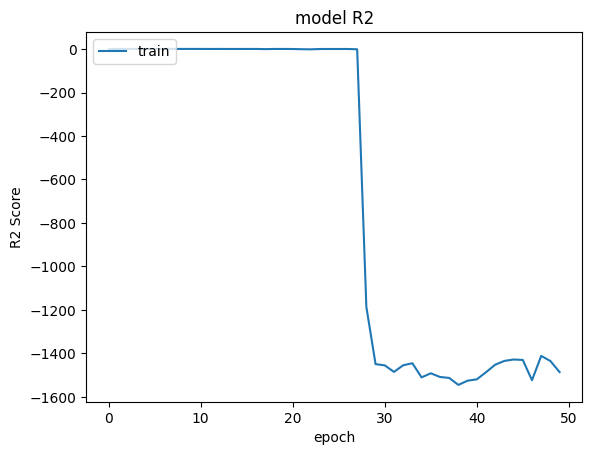

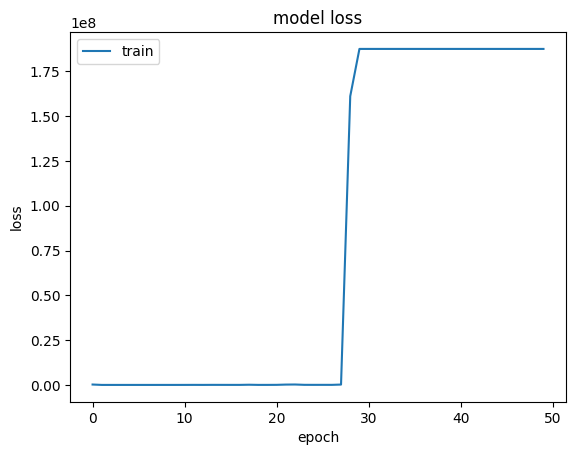

In [170]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from keras import backend as K

#This code was lifted from this website:
#https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
#
#This was done to get around an error with the R2 coefficient method that keras provided.
def custom_r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Method creates 
def sequential_model():
    
    mlp = Sequential()
    mlp.add(keras.layers.Dense(115,activation='relu',input_shape=(115,)))
    mlp.add(keras.layers.Dense(64,activation='relu'))
    mlp.add(keras.layers.Dense(32,activation='relu'))
    mlp.add(keras.layers.Dense(16,activation='relu'))
    mlp.add(keras.layers.Dense(1,activation='relu'))

    mlp.compile(loss='mse',
               optimizer=keras.optimizers.Adam(lr=0.01),
               metrics=[custom_r2])
    
    return mlp
#higher learning rate
#find another success metric
#Or find what's wrong with R2
mlp = sequential_model()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

history_nn1 = mlp.fit(
    X_train,
    y_train,  
    batch_size=10,
    #validation_data = (X_test, y_test),
    epochs=50, 
    shuffle=True, 
    verbose=1)

#Code lifted from Lab 6 of ML in Python
import matplotlib.pyplot as plt

# list all data in history
print(history_nn1.history.keys())
# summarize history for accuracy
plt.plot(history_nn1.history['custom_r2'])
#plt.plot(transfer_history.history['val_accuracy'])
plt.title('model R2')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_nn1.history['loss'])
#plt.plot(transfer_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [171]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [172]:
history_nn1 = mlp.fit(
    X_train,
    y_train,  
    batch_size=10,
    #validation_data = (X_test, y_test),
    epochs=50, 
    shuffle=True, 
    verbose=1)

Epoch 1/50
96/96 [==============================] - 1s 6ms/step - loss: 187740960.0000 - custom_r2: -1406.9293
Epoch 2/50
96/96 [==============================] - 1s 6ms/step - loss: 187740912.0000 - custom_r2: -1396.4288
Epoch 3/50
96/96 [==============================] - 1s 6ms/step - loss: 187740944.0000 - custom_r2: -1380.7374
Epoch 4/50
96/96 [==============================] - 1s 7ms/step - loss: 187740960.0000 - custom_r2: -1427.7452
Epoch 5/50
96/96 [==============================] - 1s 6ms/step - loss: 187740912.0000 - custom_r2: -1416.6554
Epoch 6/50
96/96 [==============================] - 1s 6ms/step - loss: 187740960.0000 - custom_r2: -1395.8550
Epoch 7/50
96/96 [==============================] - 1s 6ms/step - loss: 187740912.0000 - custom_r2: -1447.6718
Epoch 8/50
96/96 [==============================] - 1s 6ms/step - loss: 187740960.0000 - custom_r2: -1370.0747
Epoch 9/50
96/96 [==============================] - 1s 6ms/step - loss: 187740960.0000 - custom_r2: -1440.2611
E

dict_keys(['loss', 'custom_r2'])


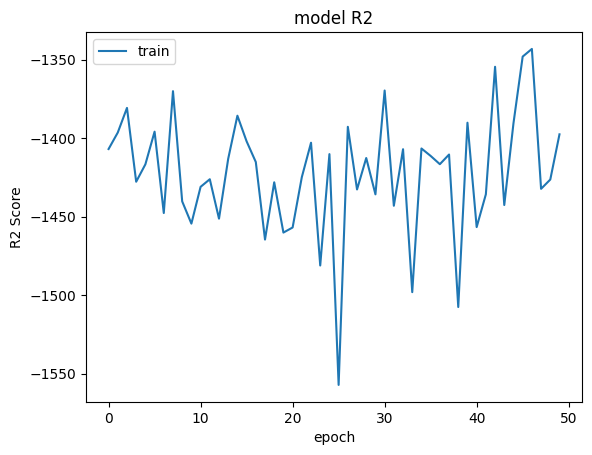

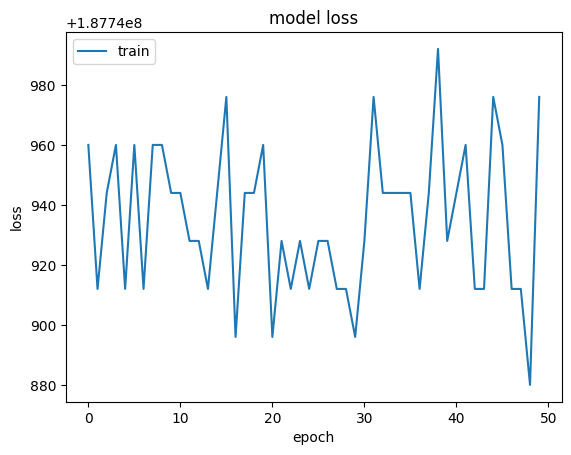

In [173]:
#Code lifted from Lab 6 of ML in Python
import matplotlib.pyplot as plt

# list all data in history
print(history_nn1.history.keys())
# summarize history for accuracy
plt.plot(history_nn1.history['custom_r2'])
#plt.plot(transfer_history.history['val_accuracy'])
plt.title('model R2')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_nn1.history['loss'])
#plt.plot(transfer_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## NN 2 No 64 Dense Layer
Another architecture with the same, except that we'll try to comment out some layers, and try some other combinations.

Epoch 1/50


2024-05-06 16:27:03.503225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 1s 6ms/step - loss: 359443.4062 - custom_r2: -1.4861
Epoch 2/50
96/96 [==============================] - 1s 6ms/step - loss: 34478.5898 - custom_r2: 0.7504
Epoch 3/50
96/96 [==============================] - 1s 6ms/step - loss: 28865.3828 - custom_r2: 0.7817
Epoch 4/50
96/96 [==============================] - 1s 6ms/step - loss: 28072.5332 - custom_r2: 0.7890
Epoch 5/50
96/96 [==============================] - 1s 6ms/step - loss: 27664.9199 - custom_r2: 0.7799
Epoch 6/50
96/96 [==============================] - 1s 6ms/step - loss: 28006.6953 - custom_r2: 0.7998
Epoch 7/50
96/96 [==============================] - 1s 6ms/step - loss: 27770.7988 - custom_r2: 0.7983
Epoch 8/50
96/96 [==============================] - 1s 6ms/step - loss: 27836.9785 - custom_r2: 0.7993
Epoch 9/50
96/96 [==============================] - 1s 5ms/step - loss: 28255.9707 - custom_r2: 0.7862
Epoch 10/50
96/96 [==============================] - 1s 6ms/step - loss: 28178.005

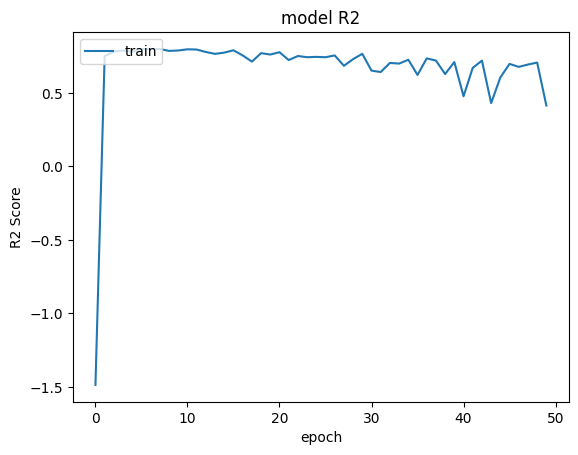

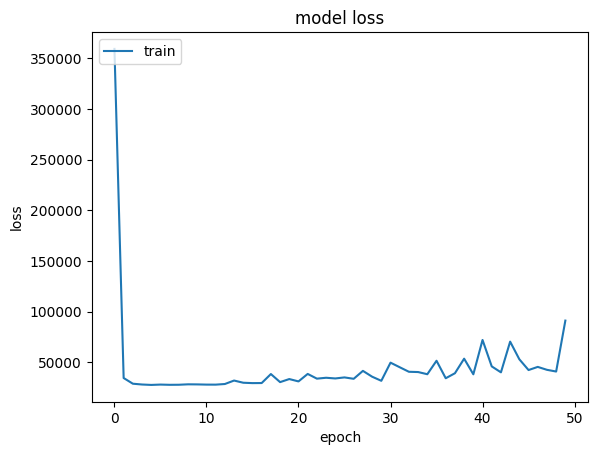

In [174]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from keras import backend as K

#This code was lifted from this website:
#https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
#
#This was done to get around an error with the R2 coefficient method that keras provided.
def custom_r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Method creates 
def sequential_model():
    
    mlp = Sequential()
    mlp.add(keras.layers.Dense(115,activation='relu',input_shape=(115,)))
    #mlp.add(keras.layers.Dense(64,activation='relu'))
    mlp.add(keras.layers.Dense(32,activation='relu'))
    mlp.add(keras.layers.Dense(16,activation='relu'))
    mlp.add(keras.layers.Dense(1,activation='relu'))

    mlp.compile(loss='mse',
               optimizer=keras.optimizers.Adam(lr=0.01),
               metrics=[custom_r2])
    
    return mlp
#higher learning rate
#find another success metric
#Or find what's wrong with R2
mlp = sequential_model()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

history_nn2 = mlp.fit(
    X_train,
    y_train,  
    batch_size=10,
    #validation_data = (X_test, y_test),
    epochs=50, 
    shuffle=True, 
    verbose=1)

#Code lifted from Lab 6 of ML in Python
import matplotlib.pyplot as plt

# list all data in history
print(history_nn2.history.keys())
# summarize history for accuracy
plt.plot(history_nn2.history['custom_r2'])
#plt.plot(transfer_history.history['val_accuracy'])
plt.title('model R2')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_nn2.history['loss'])
#plt.plot(transfer_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## NN 3 No 32 Layer

Epoch 1/50


2024-05-06 16:27:31.546922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 1s 6ms/step - loss: 269096.5625 - custom_r2: -0.9356
Epoch 2/50
96/96 [==============================] - 1s 6ms/step - loss: 30959.5625 - custom_r2: 0.7810
Epoch 3/50
96/96 [==============================] - 1s 6ms/step - loss: 29179.1758 - custom_r2: 0.7820
Epoch 4/50
96/96 [==============================] - 1s 6ms/step - loss: 28833.3086 - custom_r2: 0.7851
Epoch 5/50
96/96 [==============================] - 1s 6ms/step - loss: 29603.6172 - custom_r2: 0.7826
Epoch 6/50
96/96 [==============================] - 1s 6ms/step - loss: 29077.1250 - custom_r2: 0.7527
Epoch 7/50
96/96 [==============================] - 1s 6ms/step - loss: 30278.0195 - custom_r2: 0.7855
Epoch 8/50
96/96 [==============================] - 1s 6ms/step - loss: 28618.9551 - custom_r2: 0.7923
Epoch 9/50
96/96 [==============================] - 1s 6ms/step - loss: 28982.3379 - custom_r2: 0.7816
Epoch 10/50
96/96 [==============================] - 1s 6ms/step - loss: 29305.716

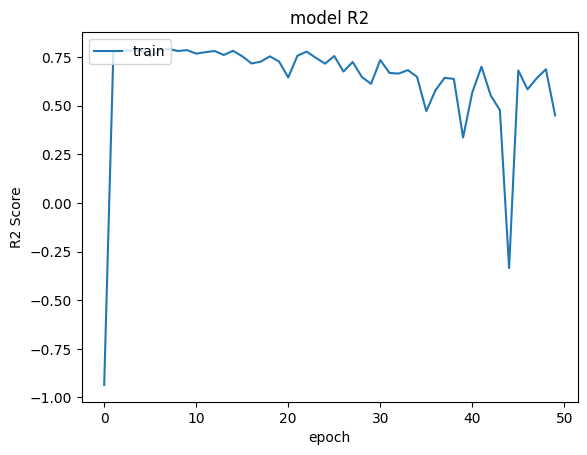

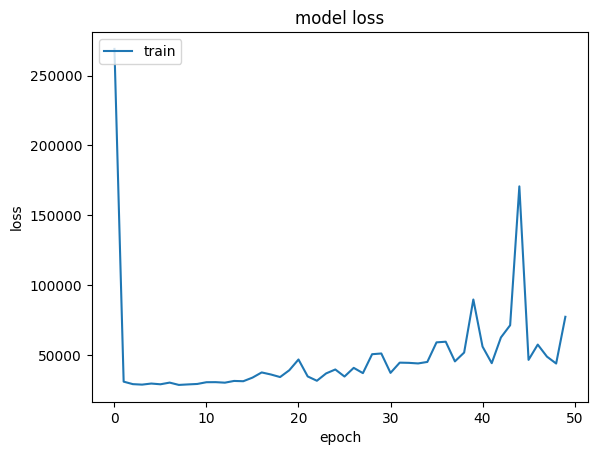

In [175]:
#This code was lifted from this website:
#https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
#
#This was done to get around an error with the R2 coefficient method that keras provided.
def custom_r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Method creates 
def sequential_model():
    
    mlp = Sequential()
    mlp.add(keras.layers.Dense(115,activation='relu',input_shape=(115,)))
    mlp.add(keras.layers.Dense(64,activation='relu'))
    #mlp.add(keras.layers.Dense(32,activation='relu'))
    mlp.add(keras.layers.Dense(16,activation='relu'))
    mlp.add(keras.layers.Dense(1,activation='relu'))

    mlp.compile(loss='mse',
               optimizer=keras.optimizers.Adam(lr=0.01),
               metrics=[custom_r2])
    
    return mlp
#higher learning rate
#find another success metric
#Or find what's wrong with R2
mlp = sequential_model()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

history_nn3 = mlp.fit(
    X_train,
    y_train,  
    batch_size=10,
    #validation_data = (X_test, y_test),
    epochs=50, 
    shuffle=True, 
    verbose=1)

# list all data in history
print(history_nn3.history.keys())
# summarize history for accuracy
plt.plot(history_nn3.history['custom_r2'])
#plt.plot(transfer_history.history['val_accuracy'])
plt.title('model R2')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_nn3.history['loss'])
#plt.plot(transfer_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## NN 4 No 16 Layer

Epoch 1/50


2024-05-06 16:27:59.577984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 1s 6ms/step - loss: 189526.8281 - custom_r2: -0.4260
Epoch 2/50
96/96 [==============================] - 1s 6ms/step - loss: 29280.1992 - custom_r2: 0.7689
Epoch 3/50
96/96 [==============================] - 1s 6ms/step - loss: 28859.0195 - custom_r2: 0.7760
Epoch 4/50
96/96 [==============================] - 1s 6ms/step - loss: 29053.2988 - custom_r2: 0.7787
Epoch 5/50
96/96 [==============================] - 1s 6ms/step - loss: 28625.5547 - custom_r2: 0.7523
Epoch 6/50
96/96 [==============================] - 1s 6ms/step - loss: 28782.9551 - custom_r2: 0.7760
Epoch 7/50
96/96 [==============================] - 1s 6ms/step - loss: 29074.4375 - custom_r2: 0.7868
Epoch 8/50
96/96 [==============================] - 1s 6ms/step - loss: 28187.7363 - custom_r2: 0.7774
Epoch 9/50
96/96 [==============================] - 1s 6ms/step - loss: 28497.9375 - custom_r2: 0.7879
Epoch 10/50
96/96 [==============================] - 1s 6ms/step - loss: 29610.105

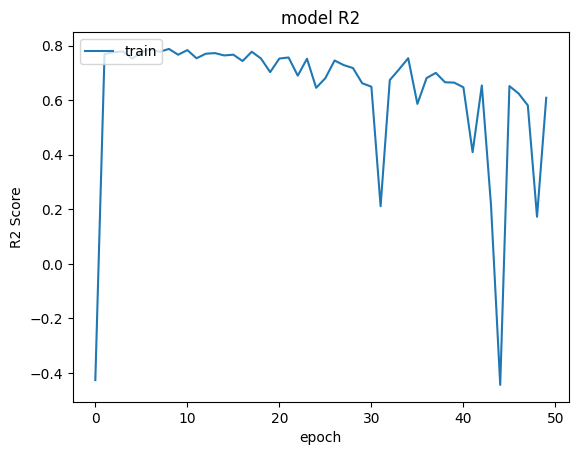

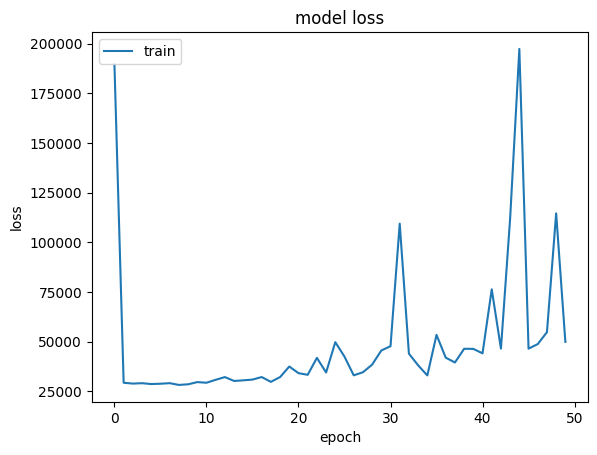

In [176]:
#This code was lifted from this website:
#https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
#
#This was done to get around an error with the R2 coefficient method that keras provided.
def custom_r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Method creates 
def sequential_model():
    
    mlp = Sequential()
    mlp.add(keras.layers.Dense(115,activation='relu',input_shape=(115,)))
    mlp.add(keras.layers.Dense(64,activation='relu'))
    mlp.add(keras.layers.Dense(32,activation='relu'))
    #mlp.add(keras.layers.Dense(16,activation='relu'))
    mlp.add(keras.layers.Dense(1,activation='relu'))

    mlp.compile(loss='mse',
               optimizer=keras.optimizers.Adam(lr=0.01),
               metrics=[custom_r2])
    
    return mlp
#higher learning rate
#find another success metric
#Or find what's wrong with R2
mlp = sequential_model()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

history_nn4 = mlp.fit(
    X_train,
    y_train,  
    batch_size=10,
    #validation_data = (X_test, y_test),
    epochs=50, 
    shuffle=True, 
    verbose=1)

#Code lifted from Lab 6 of ML in Python
import matplotlib.pyplot as plt

# list all data in history
print(history_nn4.history.keys())
# summarize history for accuracy
plt.plot(history_nn4.history['custom_r2'])
#plt.plot(transfer_history.history['val_accuracy'])
plt.title('model R2')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_nn4.history['loss'])
#plt.plot(transfer_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## NN 5 No 64 or 32 Layers

Epoch 1/50


2024-05-06 16:28:28.246124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 1s 5ms/step - loss: 443830.2188 - custom_r2: -2.1500
Epoch 2/50
96/96 [==============================] - 1s 5ms/step - loss: 44657.4609 - custom_r2: 0.6835
Epoch 3/50
96/96 [==============================] - 1s 5ms/step - loss: 29538.8320 - custom_r2: 0.7775
Epoch 4/50
96/96 [==============================] - 1s 5ms/step - loss: 26920.9434 - custom_r2: 0.7974
Epoch 5/50
96/96 [==============================] - 1s 6ms/step - loss: 26763.9707 - custom_r2: 0.8022
Epoch 6/50
96/96 [==============================] - 1s 5ms/step - loss: 26780.4141 - custom_r2: 0.8067
Epoch 7/50
96/96 [==============================] - 1s 5ms/step - loss: 26824.0332 - custom_r2: 0.7972
Epoch 8/50
96/96 [==============================] - 1s 5ms/step - loss: 27119.6855 - custom_r2: 0.7871
Epoch 9/50
96/96 [==============================] - 1s 5ms/step - loss: 26476.7930 - custom_r2: 0.7972
Epoch 10/50
96/96 [==============================] - 1s 5ms/step - loss: 26934.724

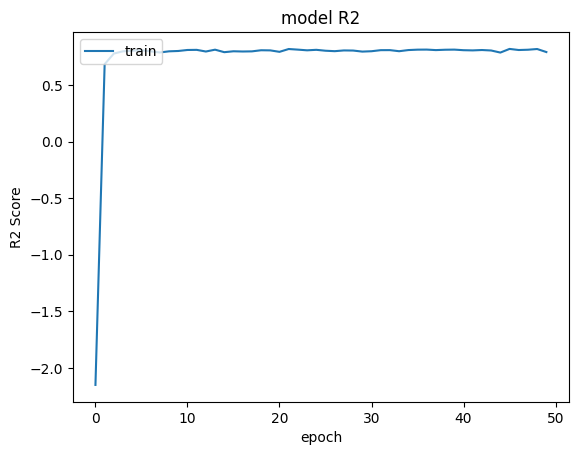

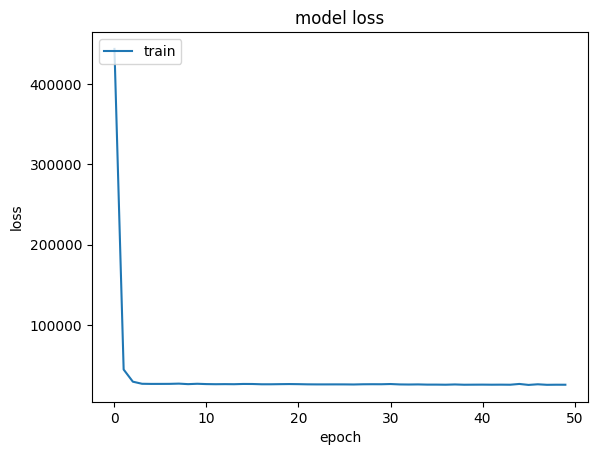

In [177]:
#This code was lifted from this website:
#https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
#
#This was done to get around an error with the R2 coefficient method that keras provided.
def custom_r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Method creates 
def sequential_model():
    
    mlp = Sequential()
    mlp.add(keras.layers.Dense(115,activation='relu',input_shape=(115,)))
    #mlp.add(keras.layers.Dense(64,activation='relu'))
    #mlp.add(keras.layers.Dense(32,activation='relu'))
    mlp.add(keras.layers.Dense(16,activation='relu'))
    mlp.add(keras.layers.Dense(1,activation='relu'))

    mlp.compile(loss='mse',
               optimizer=keras.optimizers.Adam(lr=0.01),
               metrics=[custom_r2])
    
    return mlp
#higher learning rate
#find another success metric
#Or find what's wrong with R2
mlp = sequential_model()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

history_nn5 = mlp.fit(
    X_train,
    y_train,  
    batch_size=10,
    #validation_data = (X_test, y_test),
    epochs=50, 
    shuffle=True, 
    verbose=1)

#Code lifted from Lab 6 of ML in Python
import matplotlib.pyplot as plt

# list all data in history
print(history_nn5.history.keys())
# summarize history for accuracy
plt.plot(history_nn5.history['custom_r2'])
#plt.plot(transfer_history.history['val_accuracy'])
plt.title('model R2')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_nn5.history['loss'])
#plt.plot(transfer_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## NN 6 No 64 and 16 Layer

Epoch 1/50


2024-05-06 16:28:54.746130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 1s 6ms/step - loss: 342480.8750 - custom_r2: -1.7769
Epoch 2/50
96/96 [==============================] - 1s 5ms/step - loss: 41527.2539 - custom_r2: 0.7023
Epoch 3/50
96/96 [==============================] - 1s 5ms/step - loss: 28203.0820 - custom_r2: 0.7938
Epoch 4/50
96/96 [==============================] - 1s 5ms/step - loss: 26518.4980 - custom_r2: 0.7968
Epoch 5/50
96/96 [==============================] - 1s 5ms/step - loss: 26205.6387 - custom_r2: 0.8014
Epoch 6/50
96/96 [==============================] - 1s 6ms/step - loss: 26683.0664 - custom_r2: 0.8020
Epoch 7/50
96/96 [==============================] - 1s 5ms/step - loss: 26246.2168 - custom_r2: 0.7958
Epoch 8/50
96/96 [==============================] - 1s 5ms/step - loss: 26398.2891 - custom_r2: 0.7752
Epoch 9/50
96/96 [==============================] - 1s 5ms/step - loss: 26088.5391 - custom_r2: 0.8020
Epoch 10/50
96/96 [==============================] - 1s 6ms/step - loss: 26194.250

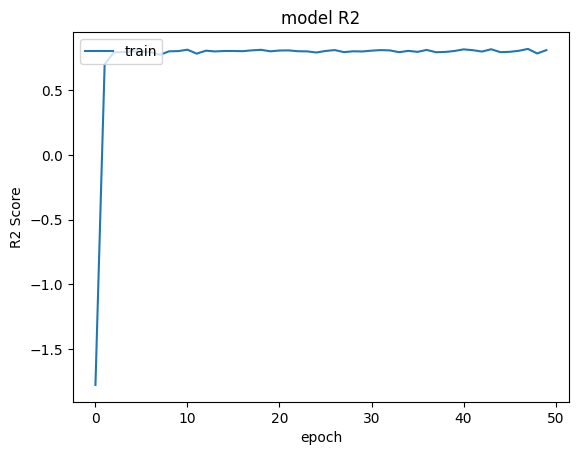

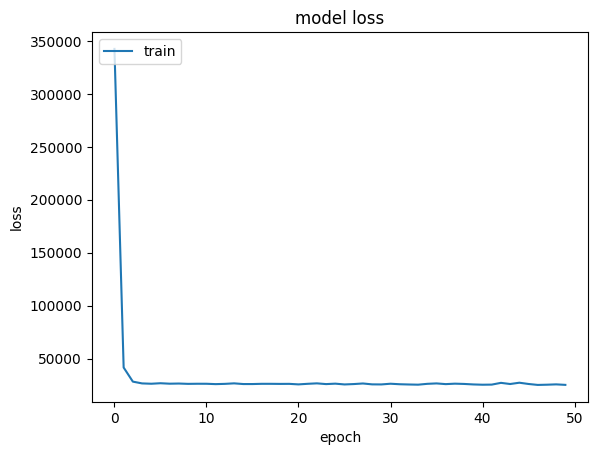

In [178]:
#This code was lifted from this website:
#https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
#
#This was done to get around an error with the R2 coefficient method that keras provided.
def custom_r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Method creates 
def sequential_model():
    
    mlp = Sequential()
    mlp.add(keras.layers.Dense(115,activation='relu',input_shape=(115,)))
    #mlp.add(keras.layers.Dense(64,activation='relu'))
    mlp.add(keras.layers.Dense(32,activation='relu'))
    #mlp.add(keras.layers.Dense(16,activation='relu'))
    mlp.add(keras.layers.Dense(1,activation='relu'))

    mlp.compile(loss='mse',
               optimizer=keras.optimizers.Adam(lr=0.01),
               metrics=[custom_r2])
    
    return mlp
#higher learning rate
#find another success metric
#Or find what's wrong with R2
mlp = sequential_model()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

history_nn6 = mlp.fit(
    X_train,
    y_train,  
    batch_size=10,
    #validation_data = (X_test, y_test),
    epochs=50, 
    shuffle=True, 
    verbose=1)

#Code lifted from Lab 6 of ML in Python
import matplotlib.pyplot as plt

# list all data in history
print(history_nn6.history.keys())
# summarize history for accuracy
plt.plot(history_nn6.history['custom_r2'])
#plt.plot(transfer_history.history['val_accuracy'])
plt.title('model R2')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_nn6.history['loss'])
#plt.plot(transfer_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## NN 7 No 32 and 16 Layers

Epoch 1/50


2024-05-06 16:29:21.820730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 1s 5ms/step - loss: 314467.8438 - custom_r2: -1.1713
Epoch 2/50
96/96 [==============================] - 1s 5ms/step - loss: 39686.7656 - custom_r2: 0.6946
Epoch 3/50
96/96 [==============================] - 1s 6ms/step - loss: 28167.1484 - custom_r2: 0.7975
Epoch 4/50
96/96 [==============================] - 1s 6ms/step - loss: 27593.8066 - custom_r2: 0.8012
Epoch 5/50
96/96 [==============================] - 1s 6ms/step - loss: 27514.3496 - custom_r2: 0.8032
Epoch 6/50
96/96 [==============================] - 1s 6ms/step - loss: 27636.2695 - custom_r2: 0.7901
Epoch 7/50
96/96 [==============================] - 1s 6ms/step - loss: 27224.2910 - custom_r2: 0.7965
Epoch 8/50
96/96 [==============================] - 1s 5ms/step - loss: 27416.4434 - custom_r2: 0.7836
Epoch 9/50
96/96 [==============================] - 1s 5ms/step - loss: 27459.0840 - custom_r2: 0.8002
Epoch 10/50
96/96 [==============================] - 1s 5ms/step - loss: 27588.300

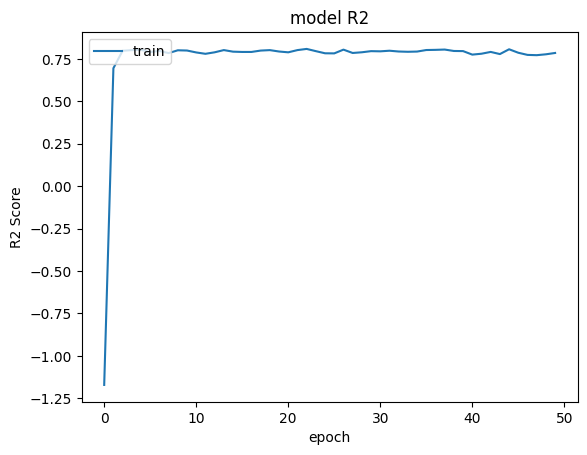

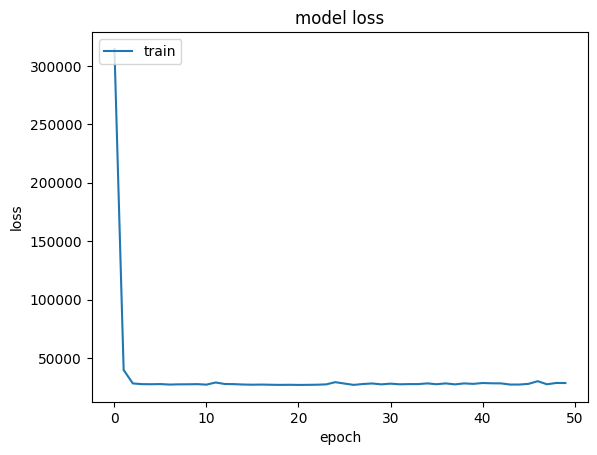

In [179]:
#This code was lifted from this website:
#https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
#
#This was done to get around an error with the R2 coefficient method that keras provided.
def custom_r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Method creates 
def sequential_model():
    
    mlp = Sequential()
    mlp.add(keras.layers.Dense(115,activation='relu',input_shape=(115,)))
    mlp.add(keras.layers.Dense(64,activation='relu'))
    #mlp.add(keras.layers.Dense(32,activation='relu'))
    #mlp.add(keras.layers.Dense(16,activation='relu'))
    mlp.add(keras.layers.Dense(1,activation='relu'))

    mlp.compile(loss='mse',
               optimizer=keras.optimizers.Adam(lr=0.01),
               metrics=[custom_r2])
    
    return mlp
#higher learning rate
#find another success metric
#Or find what's wrong with R2
mlp = sequential_model()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

history_nn7 = mlp.fit(
    X_train,
    y_train,  
    batch_size=10,
    #validation_data = (X_test, y_test),
    epochs=50, 
    shuffle=True, 
    verbose=1)

#Code lifted from Lab 6 of ML in Python
import matplotlib.pyplot as plt

# list all data in history
print(history_nn7.history.keys())
# summarize history for accuracy
plt.plot(history_nn7.history['custom_r2'])
#plt.plot(transfer_history.history['val_accuracy'])
plt.title('model R2')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_nn7.history['loss'])
#plt.plot(transfer_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## NN 8 No 64, 32, 16 layers

Epoch 1/50


2024-05-06 16:29:48.875054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 1s 5ms/step - loss: 641150.6250 - custom_r2: -3.9196
Epoch 2/50
96/96 [==============================] - 0s 5ms/step - loss: 99757.1094 - custom_r2: 0.2948
Epoch 3/50
96/96 [==============================] - 0s 5ms/step - loss: 60620.9023 - custom_r2: 0.5646
Epoch 4/50
96/96 [==============================] - 0s 5ms/step - loss: 49704.7578 - custom_r2: 0.6336
Epoch 5/50
96/96 [==============================] - 0s 5ms/step - loss: 40460.2031 - custom_r2: 0.7051
Epoch 6/50
96/96 [==============================] - 0s 5ms/step - loss: 33708.7656 - custom_r2: 0.7602
Epoch 7/50
96/96 [==============================] - 0s 5ms/step - loss: 29486.2559 - custom_r2: 0.7702
Epoch 8/50
96/96 [==============================] - 0s 5ms/step - loss: 27393.3887 - custom_r2: 0.8004
Epoch 9/50
96/96 [==============================] - 1s 6ms/step - loss: 26615.7617 - custom_r2: 0.7980
Epoch 10/50
96/96 [==============================] - 1s 5ms/step - loss: 26173.052

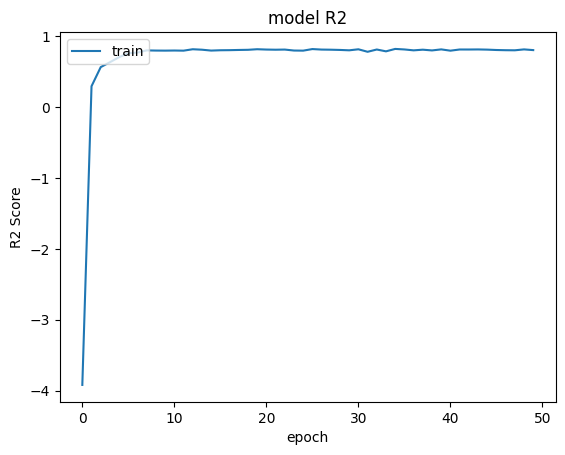

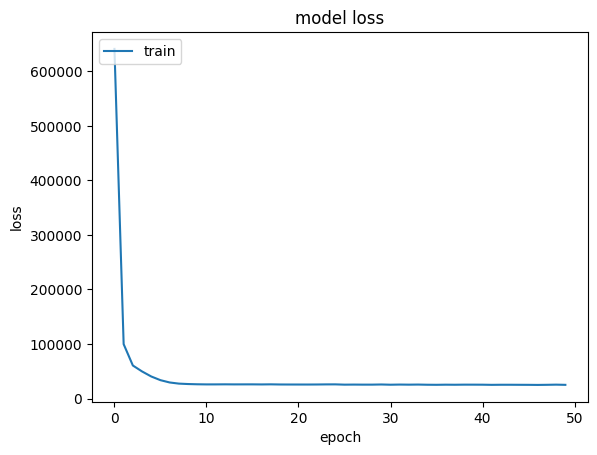

In [180]:
#This code was lifted from this website:
#https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
#
#This was done to get around an error with the R2 coefficient method that keras provided.
def custom_r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Method creates 
def sequential_model():
    
    mlp = Sequential()
    mlp.add(keras.layers.Dense(115,activation='relu',input_shape=(115,)))
    #mlp.add(keras.layers.Dense(64,activation='relu'))
    #mlp.add(keras.layers.Dense(32,activation='relu'))
    #mlp.add(keras.layers.Dense(16,activation='relu'))
    mlp.add(keras.layers.Dense(1,activation='relu'))

    mlp.compile(loss='mse',
               optimizer=keras.optimizers.Adam(lr=0.01),
               metrics=[custom_r2])
    
    return mlp
#higher learning rate
#find another success metric
#Or find what's wrong with R2
mlp = sequential_model()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

history_nn8 = mlp.fit(
    X_train,
    y_train,  
    batch_size=10,
    #validation_data = (X_test, y_test),
    epochs=50, 
    shuffle=True, 
    verbose=1)

#Code lifted from Lab 6 of ML in Python
import matplotlib.pyplot as plt

# list all data in history
print(history_nn8.history.keys())
# summarize history for accuracy
plt.plot(history_nn8.history['custom_r2'])
#plt.plot(transfer_history.history['val_accuracy'])
plt.title('model R2')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_nn8.history['loss'])
#plt.plot(transfer_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Since none of these seemed to have a major impact on the R2 Score. Let's try adding a Batch Normalization Layer, to see if the Batch Normalization will smooth out all the values and prevent overfitting.

## NN 9 With Batch Normalization Layer

Epoch 1/50


2024-05-06 16:30:12.682983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 2s 7ms/step - loss: 1198863.3750 - custom_r2: -8.8664
Epoch 2/50
96/96 [==============================] - 1s 7ms/step - loss: 1314440.0000 - custom_r2: -9.3187
Epoch 3/50
96/96 [==============================] - 1s 7ms/step - loss: 1373978.5000 - custom_r2: -9.7685
Epoch 4/50
96/96 [==============================] - 1s 7ms/step - loss: 900262.3750 - custom_r2: -5.9592
Epoch 5/50
96/96 [==============================] - 1s 7ms/step - loss: 182399.8438 - custom_r2: -0.4525
Epoch 6/50
96/96 [==============================] - 1s 7ms/step - loss: 45641.6914 - custom_r2: 0.6438
Epoch 7/50
96/96 [==============================] - 1s 7ms/step - loss: 43874.7539 - custom_r2: 0.6193
Epoch 8/50
96/96 [==============================] - 1s 7ms/step - loss: 44880.6836 - custom_r2: 0.5631
Epoch 9/50
96/96 [==============================] - 1s 9ms/step - loss: 41393.0820 - custom_r2: 0.5985
Epoch 10/50
96/96 [==============================] - 1s 8ms/step - loss

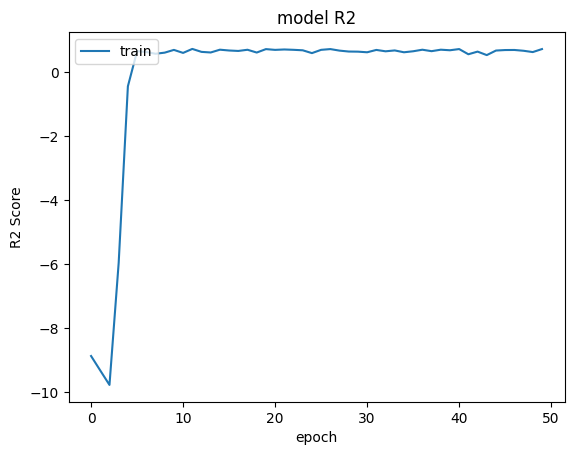

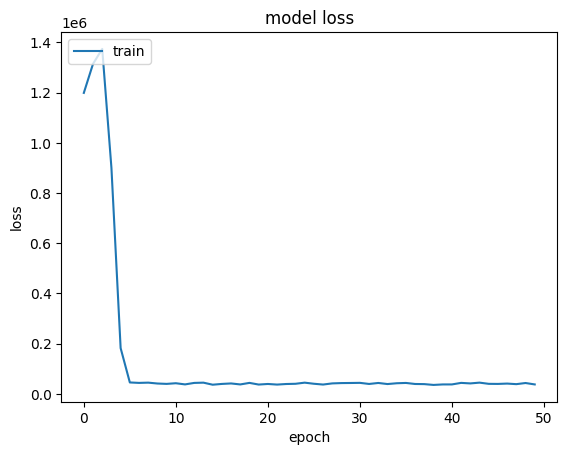

In [181]:
#This code was lifted from this website:
#https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
#
#This was done to get around an error with the R2 coefficient method that keras provided.
def custom_r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Method creates 
def sequential_model():
    
    mlp = Sequential()
    mlp.add(keras.layers.Dense(115,activation='relu',input_shape=(115,)))
    mlp.add(keras.layers.BatchNormalization())
    mlp.add(keras.layers.Dense(64,activation='relu'))
    #mlp.add(keras.layers.Dense(32,activation='relu'))
    #mlp.add(keras.layers.Dense(16,activation='relu'))
    mlp.add(keras.layers.Dense(1,activation='relu'))

    mlp.compile(loss='mse',
               optimizer=keras.optimizers.Adam(lr=0.01),
               metrics=[custom_r2])
    
    return mlp
#higher learning rate
#find another success metric
#Or find what's wrong with R2
mlp = sequential_model()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

history_nn9 = mlp.fit(
    X_train,
    y_train,  
    batch_size=10,
    #validation_data = (X_test, y_test),
    epochs=50, 
    shuffle=True, 
    verbose=1)

#Code lifted from Lab 6 of ML in Python
import matplotlib.pyplot as plt

# list all data in history
print(history_nn9.history.keys())
# summarize history for accuracy
plt.plot(history_nn9.history['custom_r2'])
#plt.plot(transfer_history.history['val_accuracy'])
plt.title('model R2')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_nn9.history['loss'])
#plt.plot(transfer_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Batch Normalization Layer didn't seem to do much to improve the R2 Score of the Network, and in fact, it converges slower.

## NN 10 MinMaxScaling the Dataset with only 115 and 64 Layers

Epoch 1/50


2024-05-06 16:30:48.821772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 1s 6ms/step - loss: 0.1024 - custom_r2: -0.5249
Epoch 2/50
96/96 [==============================] - 1s 5ms/step - loss: 0.0225 - custom_r2: 0.6846
Epoch 3/50
96/96 [==============================] - 1s 5ms/step - loss: 0.0236 - custom_r2: 0.6394
Epoch 4/50
96/96 [==============================] - 1s 5ms/step - loss: 0.0191 - custom_r2: 0.7221
Epoch 5/50
96/96 [==============================] - 1s 5ms/step - loss: 0.0175 - custom_r2: 0.7342
Epoch 6/50
96/96 [==============================] - 1s 5ms/step - loss: 0.0173 - custom_r2: 0.7415
Epoch 7/50
96/96 [==============================] - 1s 5ms/step - loss: 0.0177 - custom_r2: 0.7419
Epoch 8/50
96/96 [==============================] - 1s 5ms/step - loss: 0.0180 - custom_r2: 0.7433
Epoch 9/50
96/96 [==============================] - 1s 5ms/step - loss: 0.0164 - custom_r2: 0.7587
Epoch 10/50
96/96 [==============================] - 0s 5ms/step - loss: 0.0176 - custom_r2: 0.7497
Epoch 11/50
96/96 [

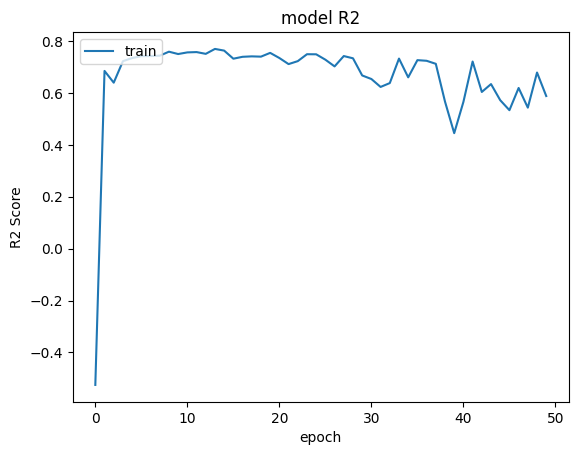

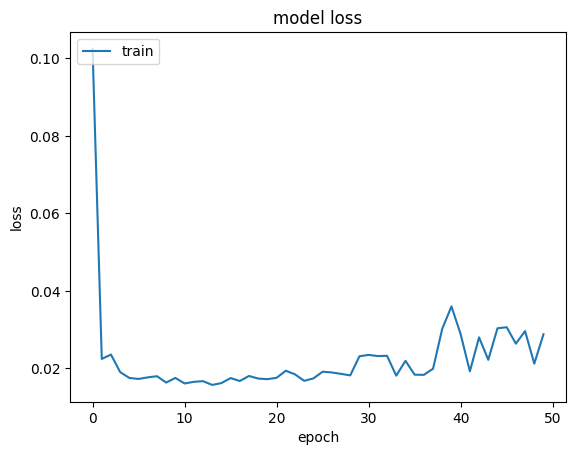

In [182]:
from sklearn.preprocessing import MinMaxScaler

# Assume filtered_data is already converted to a NumPy array and is a float type
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Scale the features
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Scale the target variable

#This code was lifted from this website:
#https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
#
#This was done to get around an error with the R2 coefficient method that keras provided.
def custom_r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Method creates 
def sequential_model():
    
    mlp = Sequential()
    mlp.add(keras.layers.Dense(115,activation='relu',input_shape=(115,)))
    #mlp.add(keras.layers.BatchNormalization())
    mlp.add(keras.layers.Dense(64,activation='relu'))
    #mlp.add(keras.layers.Dense(32,activation='relu'))
    #mlp.add(keras.layers.Dense(16,activation='relu'))
    mlp.add(keras.layers.Dense(1,activation='relu'))

    mlp.compile(loss='mse',
               optimizer=keras.optimizers.Adam(lr=0.01),
               metrics=[custom_r2])
    
    return mlp
#higher learning rate
#find another success metric
#Or find what's wrong with R2
mlp = sequential_model()


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2)#, random_state=42)

history_nn10 = mlp.fit(
    X_train,
    y_train,  
    batch_size=10,
    #validation_data = (X_test, y_test),
    epochs=50, 
    shuffle=True, 
    verbose=1)

#Code lifted from Lab 6 of ML in Python
import matplotlib.pyplot as plt

# list all data in history
print(history_nn10.history.keys())
# summarize history for accuracy
plt.plot(history_nn10.history['custom_r2'])
#plt.plot(transfer_history.history['val_accuracy'])
plt.title('model R2')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_nn10.history['loss'])
#plt.plot(transfer_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [221]:
df_results_nn1 = pd.DataFrame.from_dict(history_nn1.history, orient='columns')
df_results_nn1['Model'] = 'NN1'
df_results_nn1['Epoch'] = list(range(1, 51))
df_results_nn1 = df_results_nn1.rename(columns={"loss":"MSE", 'custom_r2':"R2"})

df_results_nn2 = pd.DataFrame.from_dict(history_nn2.history, orient='columns')
df_results_nn2['Model'] = 'NN2'
df_results_nn2['Epoch'] = list(range(1, 51))
df_results_nn2 = df_results_nn2.rename(columns={"loss":"MSE", 'custom_r2':"R2"})

df_results_nn3 = pd.DataFrame.from_dict(history_nn3.history, orient='columns')
df_results_nn3['Model'] = 'NN3'
df_results_nn3['Epoch'] = list(range(1, 51))
df_results_nn3 = df_results_nn3.rename(columns={"loss":"MSE", 'custom_r2':"R2"})

df_results_nn4 = pd.DataFrame.from_dict(history_nn4.history, orient='columns')
df_results_nn4['Model'] = 'NN4'
df_results_nn4['Epoch'] = list(range(1, 51))
df_results_nn4 = df_results_nn4.rename(columns={"loss":"MSE", 'custom_r2':"R2"})

df_results_nn5 = pd.DataFrame.from_dict(history_nn5.history, orient='columns')
df_results_nn5['Model'] = 'NN5'
df_results_nn5['Epoch'] = list(range(1, 51))
df_results_nn5 = df_results_nn5.rename(columns={"loss":"MSE", 'custom_r2':"R2"})

df_results_nn6 = pd.DataFrame.from_dict(history_nn6.history, orient='columns')
df_results_nn6['Model'] = 'NN6'
df_results_nn6['Epoch'] = list(range(1, 51))
df_results_nn6 = df_results_nn6.rename(columns={"loss":"MSE", 'custom_r2':"R2"})

df_results_nn7 = pd.DataFrame.from_dict(history_nn7.history, orient='columns')
df_results_nn7['Model'] = 'NN7'
df_results_nn7['Epoch'] = list(range(1, 51))
df_results_nn7 = df_results_nn7.rename(columns={"loss":"MSE", 'custom_r2':"R2"})

df_results_nn8 = pd.DataFrame.from_dict(history_nn8.history, orient='columns')
df_results_nn8['Model'] = 'NN8'
df_results_nn8['Epoch'] = list(range(1, 51))
df_results_nn8 = df_results_nn8.rename(columns={"loss":"MSE", 'custom_r2':"R2"})

df_results_nn9 = pd.DataFrame.from_dict(history_nn9.history, orient='columns')
df_results_nn9['Model'] = 'NN9'
df_results_nn9['Epoch'] = list(range(1, 51))
df_results_nn9 = df_results_nn9.rename(columns={"loss":"MSE", 'custom_r2':"R2"})

df_results_nn10 = pd.DataFrame.from_dict(history_nn10.history, orient='columns')
df_results_nn10['Model'] = 'NN10'
df_results_nn10['Epoch'] = list(range(1, 51))
df_results_nn10 = df_results_nn10.rename(columns={"loss":"MSE", 'custom_r2':"R2"})

In [238]:
nn_results_concat = pd.concat([df_results_nn10,
                               df_results_nn9,
                               df_results_nn8,
                               df_results_nn7,
                               df_results_nn6,
                               df_results_nn5,
                               df_results_nn4,
                               df_results_nn3,
                               df_results_nn2])

[Text(0.5, 1.0, 'R2 Scores of Neural Networks 2-10')]

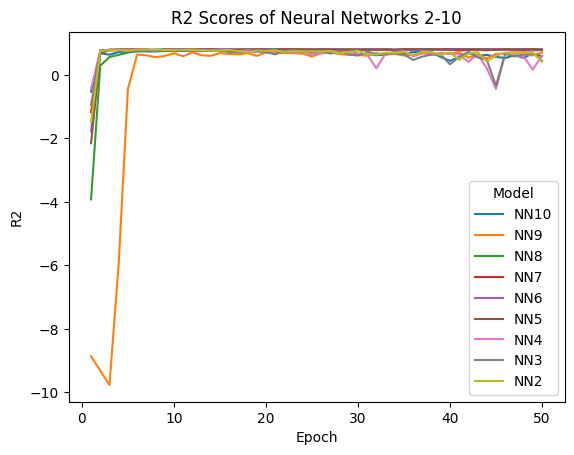

In [251]:
sns.lineplot(data=nn_results_concat[['Epoch','R2', 'Model']], x = 'Epoch', y='R2', hue='Model').set(title ='R2 Scores of Neural Networks 2-10')

[Text(0.5, 1.0, 'MSE Scores of Neural Networks 2-10')]

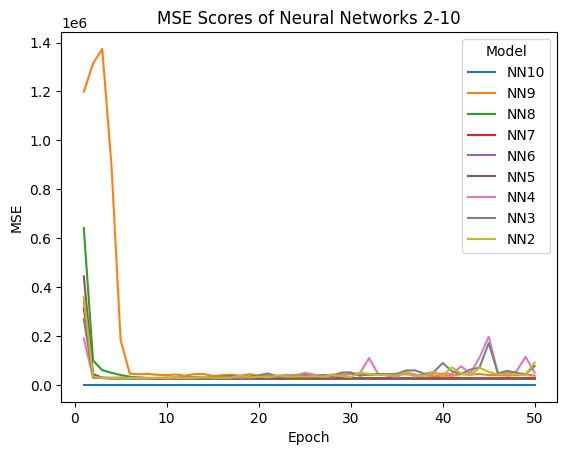

In [252]:
sns.lineplot(data=nn_results_concat[['Epoch','MSE', 'Model']], x = 'Epoch', y='MSE', hue='Model').set(title ='MSE Scores of Neural Networks 2-10')

[Text(0.5, 1.0, 'R2 Scores of Neural Network 1')]

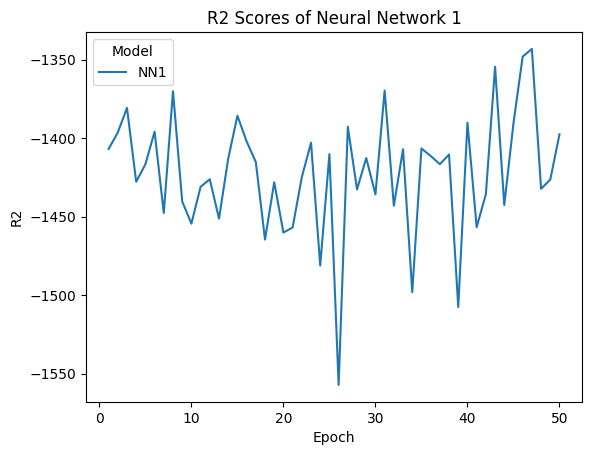

In [249]:
sns.lineplot(data=df_results_nn1, x = 'Epoch', y='R2', hue='Model').set(title ='R2 Scores of Neural Network 1')

[Text(0.5, 1.0, 'MSE Scores of Neural Network 1')]

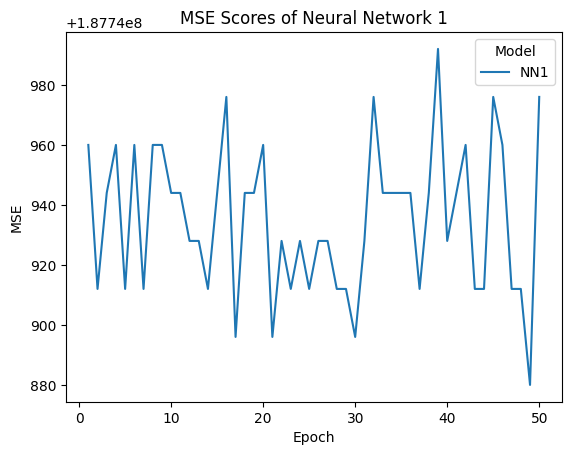

In [250]:
sns.lineplot(data=df_results_nn1, x = 'Epoch', y='MSE', hue='Model').set(title ='MSE Scores of Neural Network 1')

### Past the 10th Epoch to have a closer look at convergence

[Text(0.5, 1.0, 'R2 Scores of Neural Networks 2-10')]

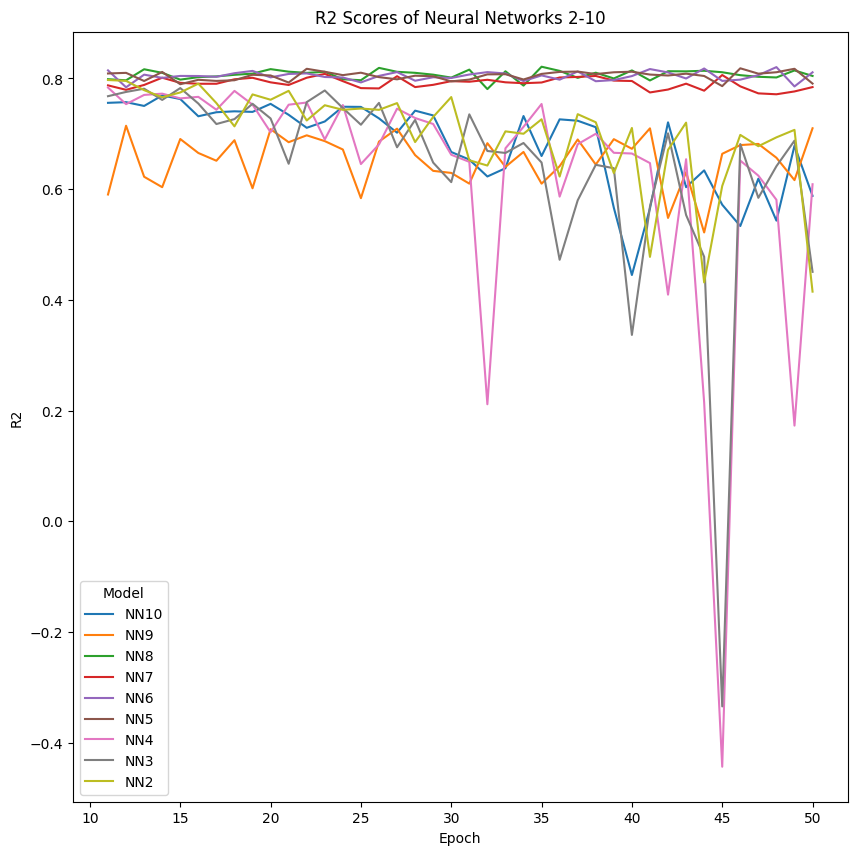

In [263]:
nn_results_concat_2 = nn_results_concat[nn_results_concat.Epoch > 10]
fig, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(data=nn_results_concat_2[['Epoch','R2', 'Model']], x = 'Epoch', y='R2', hue='Model', ax=ax).set(title ='R2 Scores of Neural Networks 2-10')

[Text(0.5, 1.0, 'MSE Scores of Neural Networks 2-10')]

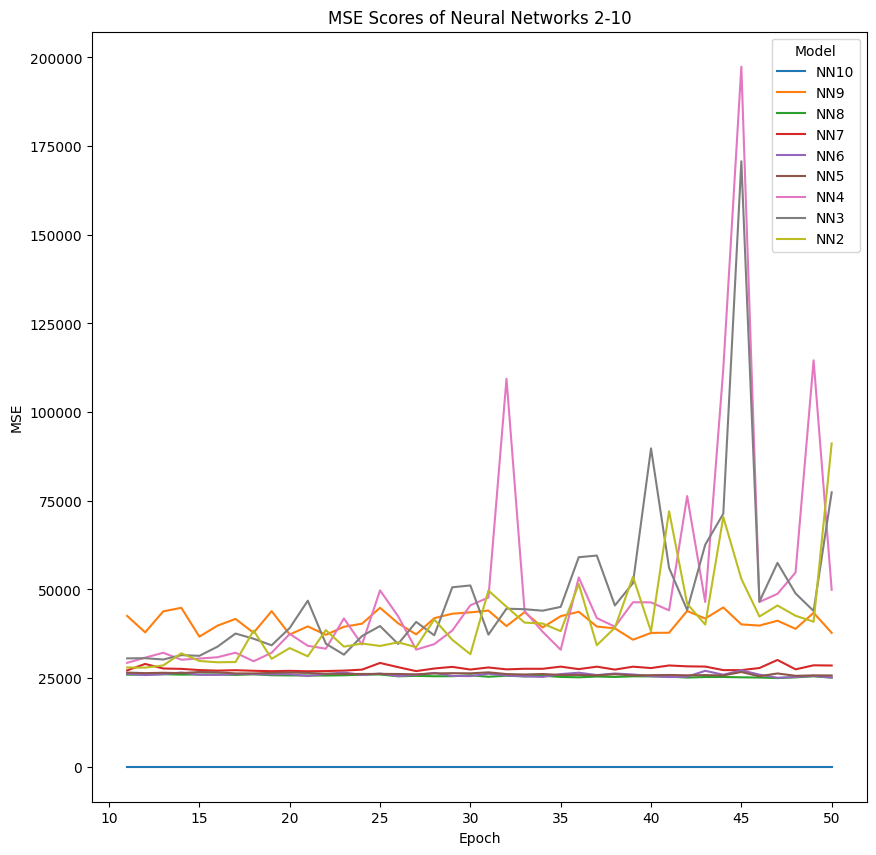

In [281]:
nn_results_concat_2 = nn_results_concat[nn_results_concat.Epoch > 10]
fig, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(data=nn_results_concat_2[['Epoch','MSE', 'Model']], x = 'Epoch', y='MSE', hue='Model', ax=ax).set(title ='MSE Scores of Neural Networks 2-10')

In [270]:
#Method creates 
def sequential_model():
    
    mlp = Sequential()
    mlp.add(keras.layers.Dense(115,activation='relu',input_shape=(115,)))
    mlp.add(keras.layers.Dense(64,activation='relu'))
    mlp.add(keras.layers.Dense(32,activation='relu'))
    mlp.add(keras.layers.Dense(16,activation='relu'))
    mlp.add(keras.layers.Dense(1,activation='relu'))

    mlp.compile(loss='mse',
               optimizer=keras.optimizers.Adam(lr=0.01),
               metrics=[custom_r2])
    
    return mlp
#higher learning rate
#find another success metric
#Or find what's wrong with R2
mlp = sequential_model()

mlp.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 115)               13340     
                                                                 
 dense_45 (Dense)            (None, 64)                7424      
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 16)                528       
                                                                 
 dense_48 (Dense)            (None, 1)                 17        
                                                                 
Total params: 23389 (91.36 KB)
Trainable params: 23389 (91.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [271]:
#Method creates 
def sequential_model():
    
    mlp = Sequential()
    mlp.add(keras.layers.Dense(115,activation='relu',input_shape=(115,)))
    mlp.add(keras.layers.BatchNormalization())
    mlp.add(keras.layers.Dense(64,activation='relu'))
    #mlp.add(keras.layers.Dense(32,activation='relu'))
    #mlp.add(keras.layers.Dense(16,activation='relu'))
    mlp.add(keras.layers.Dense(1,activation='relu'))

    mlp.compile(loss='mse',
               optimizer=keras.optimizers.Adam(lr=0.01),
               metrics=[custom_r2])
    
    return mlp
#higher learning rate
#find another success metric
#Or find what's wrong with R2
mlp = sequential_model()
mlp.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 115)               13340     
                                                                 
 batch_normalization_1 (Bat  (None, 115)               460       
 chNormalization)                                                
                                                                 
 dense_50 (Dense)            (None, 64)                7424      
                                                                 
 dense_51 (Dense)            (None, 1)                 65        
                                                                 
Total params: 21289 (83.16 KB)
Trainable params: 21059 (82.26 KB)
Non-trainable params: 230 (920.00 Byte)
_________________________________________________________________
